<a href="https://colab.research.google.com/github/madhugopinathan/deep-nlu/blob/master/word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Word Embeddings

In [1]:
!pip install -U torchtext

     |████████████████████████████████| 71kB 2.0MB/s 
     |████████████████████████████████| 1.1MB 6.5MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import torch
import torchtext
from torchtext.vocab import GloVe
import umap

In [4]:
pd.options.display.max_colwidth=-1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Visualize and explore neighbourhood of word embeddings (Glove)

In [5]:
glove = GloVe(name = '840B', dim = 300)

.vector_cache/glove.840B.300d.zip: 2.18GB [16:57, 2.14MB/s]                            
100%|█████████▉| 2195879/2196017 [05:39<00:00, 6883.00it/s]

In [7]:
def get_word_vec(word):
  assert word in glove.stoi, f"{word} is OOV!"
  vec = glove.vectors[glove.stoi[word]]
  return vec


def cosine_similarity(word1, word2):
  vec1 = get_word_vec(word1)
  vec2 = get_word_vec(word2)
  return torch.cosine_similarity(vec1.unsqueeze(0),
                                 vec2.unsqueeze(0)).item()


def get_nearest_neighbours(word_or_vec, n=10):
    vec = None
    if isinstance(word_or_vec, str):
        vec = get_word_vec(word_or_vec)
    else:
        vec = word_or_vec
        
    topn =  torch.argsort(torch.mv(glove.vectors, vec), descending=True)[:n]
        
    return [glove.itos[idx] for idx in topn]

In [8]:
def plot_embeddings(words):
  fig, axes = plt.subplots(nrows=len(words), 
                           ncols=1, 
                           sharex=True, 
                           figsize=(20,len(words)))

  for ax, w in zip(axes.flat, words):
    im = ax.imshow(glove.vectors[glove.stoi[w]].view(1,-1), 
                   cmap=plt.cm.coolwarm)
    ax.set_aspect('auto')

  fig.subplots_adjust(right=0.8)
  cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
  fig.colorbar(im, cax=cbar_ax)

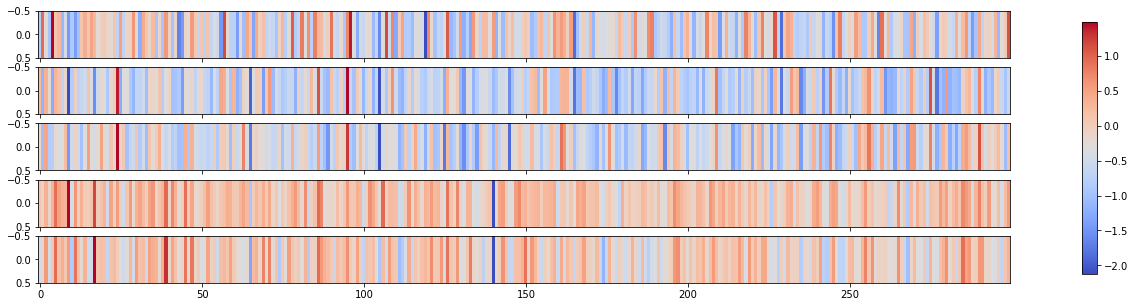

In [9]:
words = ['gurgaon','paratha','dosa', 'pizza', 'pasta']
plot_embeddings(words)

In [10]:
from sklearn.metrics.pairwise import cosine_similarity as mat_cosine_similarity

In [11]:
E = torch.stack([get_word_vec(w) for w in words], 
            dim=0)

In [12]:
csim = mat_cosine_similarity(E)

In [13]:
csim

array([[0.99999976, 0.13655838, 0.14006974, 0.01849766, 0.00368263],
       [0.13655838, 1.        , 0.69100374, 0.30521113, 0.3712668 ],
       [0.14006974, 0.69100374, 0.9999999 , 0.3093319 , 0.38042688],
       [0.01849766, 0.30521113, 0.3093319 , 0.9999999 , 0.7369544 ],
       [0.00368263, 0.3712668 , 0.38042688, 0.7369544 , 0.99999964]],
      dtype=float32)

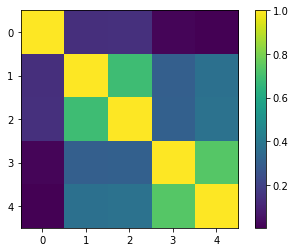

In [14]:
plt.imshow(csim)
plt.colorbar();

In [15]:
foods = ['chapati','chana','bhatura','chole','dal',
         'poha','idli','upma','dosa','puri',
         'paratha','jalebi','kachori','khichdi','kofta']

places = ['gurgaon','faridabad','lucknow','noida','delhi',
          'koramangala','bangalore','goa','panaji','coorg',
          'ladakh','amritsar','hyderabad','mumbai','varanasi'
         ]

food_places_df = pd.DataFrame(data={'word' : foods + places, 
                                    'type' : ['food'] * len(foods) + 
                                             ['place'] * len(places)})

In [16]:
food_places_df.sample(5)

,word,type
0,chapati,food
22,goa,place
2,bhatura,food
13,khichdi,food
24,coorg,place


In [17]:
E = torch.stack([get_word_vec(row.word) for _,row in food_places_df.iterrows()], 
            dim=0)

In [18]:
E.shape

torch.Size([30, 300])

In [19]:
fit = umap.UMAP(n_neighbors=5, random_state=42, metric='cosine')
u = fit.fit_transform(E)

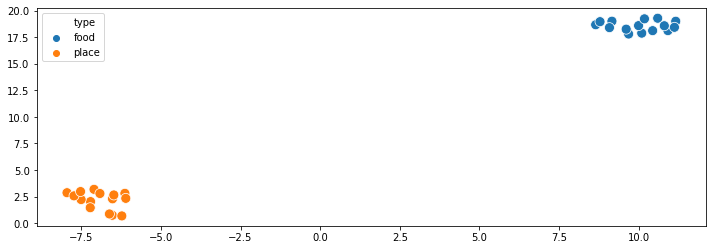

In [20]:
fig, ax = plt.subplots(figsize=(12,4))
sns.scatterplot(u[:,0], u[:,1], ax=ax, hue=food_places_df.type, s=100);

In [21]:
glove.vectors.shape

torch.Size([2196017, 300])

In [22]:
num_points = 10000
indices = np.random.choice(glove.vectors.shape[0],size=num_points, 
                           replace=False)

E = glove.vectors[indices]
fit = umap.UMAP(n_neighbors=10, random_state=42, metric='cosine')
u = fit.fit_transform(E)

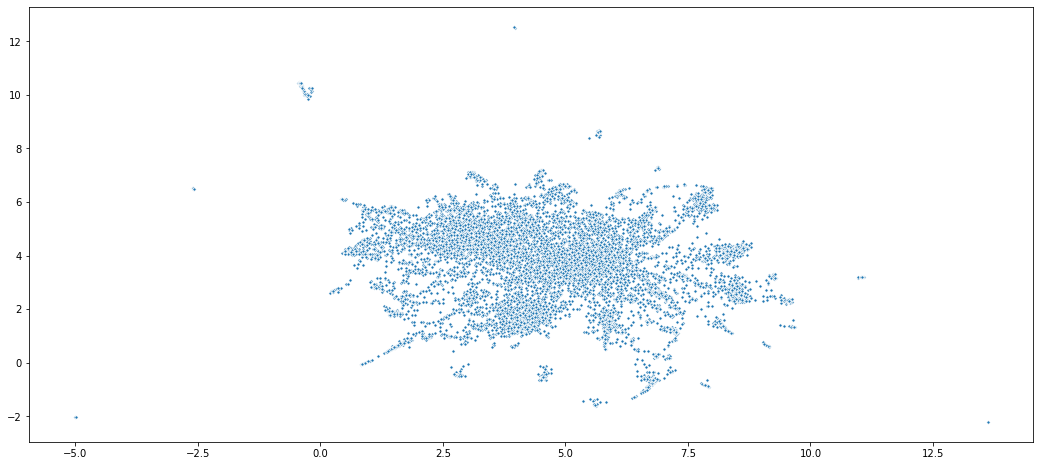

In [23]:
fig, ax = plt.subplots(figsize=(18,8))
sns.scatterplot(u[:,0], u[:,1], ax=ax, s=10);

## References
1. [The Illustrated Word2Vec](http://jalammar.github.io/illustrated-word2vec/)
1. [Uniform Manifold Approximation and Projection (UMAP)](https://github.com/lmcinnes/umap)


In [24]:
def get_missing_word(a,b,c):
  avec = get_word_vec(a)
  bvec = get_word_vec(b)
  cvec = get_word_vec(c)
   
  dvec = cvec + bvec - avec
  candidates = get_nearest_neighbours(dvec, n=5)

  input_words = [a.lower(), b.lower(), c.lower()]
  candidates = [el for el in candidates if el.lower() not in input_words]
  return candidates[0]

In [25]:
get_missing_word('man','woman','king')

'queen'

In [26]:
get_missing_word('delhi','india','tokyo')

'japan'

In [27]:
get_missing_word('dosa','india','croissant')

'france'

## Representation of the gender concept

In [28]:
gender_pairs = [('she','he'),
                ('her','his'),
                ('woman','man'),
                ('daughter','son'),
                ('mother','father'),
               ]
words = [el for pair in gender_pairs for el in pair]
gender_df = pd.DataFrame(data={'gender' : ['female', 'male'] * len(gender_pairs),
                               'word' : words
                              })

In [29]:
gender_df

,gender,word
0,female,she
1,male,he
2,female,her
3,male,his
4,female,woman
5,male,man
6,female,daughter
7,male,son
8,female,mother
9,male,father


In [30]:
X = torch.stack([get_word_vec(w) for w in gender_df.word], dim=0)


In [31]:
X.shape

torch.Size([10, 300])

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [33]:
pipe = Pipeline([('scaler',StandardScaler()),
                 ('pca', PCA(n_components=2))
                ])

In [34]:
X_reduced = pipe.fit_transform(X)

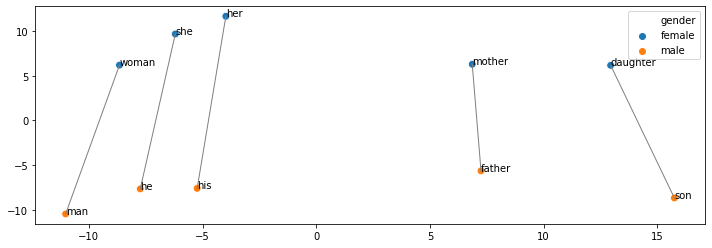

In [35]:
fig, ax = plt.subplots(figsize=(12,4))

sns.scatterplot(X_reduced[:,0], X_reduced[:,1], ax=ax, hue=gender_df.gender, s=60)

for i, word in enumerate(words):
    ax.annotate(word, (X_reduced[i,0], X_reduced[i,1]))
    
for i in range(0, X_reduced.shape[0], 2):
    ax.plot(X_reduced[i:i+2,0], X_reduced[i:i+2,1], c='gray', linewidth=1)

In [36]:
vecs = []
for i in range(0, X.shape[0], 2):
    a = X[i,:]
    b = X[i+1,:]
    mean_vec = (a+b)/2
    vecs.append(a-mean_vec)
    vecs.append(b-mean_vec)
X1 = torch.stack(vecs, dim=0)

In [37]:
X1_reduced = pipe.fit_transform(X1)


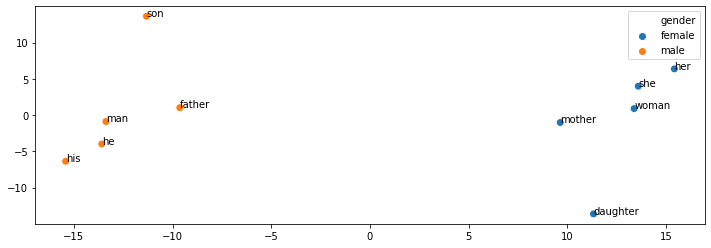

In [38]:
fig, ax = plt.subplots(figsize=(12,4))

sns.scatterplot(X1_reduced[:,0], X1_reduced[:,1], ax=ax, hue=gender_df.gender, s=60)

for i, word in enumerate(words):
    ax.annotate(word, (X1_reduced[i,0], X1_reduced[i,1]))

In [39]:
vecs = []
for i in range(0, X1.shape[0], 2):
    a = X[i,:]
    b = X[i+1,:]
    vecs.append(b-a)
X2 = torch.stack(vecs, dim=0)

In [40]:
gender_vector = X2.mean(dim=0)


In [41]:
def get_masculine_word(feminine_word):
  word_vector = get_word_vec(feminine_word)
  candidates = get_nearest_neighbours(word_vector + gender_vector)
  return [c for c in candidates if c not in [feminine_word, feminine_word+"s"]][0]

In [42]:
get_masculine_word('headmistress')

'headmaster'

In [43]:
get_masculine_word('daughter-in-law')


'son-in-law'

In [44]:
get_masculine_word('step-mother')


'step-father'

In [45]:
get_masculine_word('mother-in-law')


'father-in-law'

In [46]:
get_masculine_word('step-daughter')


'step-son'

In [47]:
get_masculine_word('stepdaughter')


'stepson'

In [48]:
get_masculine_word('policewoman')


'policeman'

In [49]:
get_masculine_word('chairwoman')


'chairman'

# Exercise: Compute the concept vector & predict!

pairs = [('good','bad'),
         ('beautiful','ugly'),
         ('interesting','boring'),
         ('clean','dirty'),
         ('safe','dangerous')]

test_words = ['terrific', 'fantastic', 'pretty', 'nice', 'innocent', 'expensive']

# Applications

* [Concept Search using Word Embeddings](https://cxlabs.sap.com/2018/06/11/concept-search-by-word-embeddings/)

# Approximate Nearest Neighbour Search

In [50]:
!pip install annoy

     |████████████████████████████████| 645kB 2.8MB/s 
  Created wheel for annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=297344 sha256=701697d68b5bc6db802f8204d190df2a04f695916b3dcc4e671b948cea5d9bc3
  Stored in directory: /root/.cache/pip/wheels/f3/01/54/6ef760fe9f9fc6ba8c19cebbe6358212b5f3b5b0195c0b813f
Successfully built annoy


In [51]:
from annoy import AnnoyIndex

In [69]:
dim = 300
ann_index = AnnoyIndex(dim, 'angular') 

In [70]:
items = foods + places
for i, item in enumerate(items):
  ann_index.add_item(i, glove.vectors[glove.stoi[item]])

In [71]:
ann_index.build(10) # build 10 trees

True

In [72]:
ann_index.save('glove_items.ann')

True

In [73]:
items

['chapati',
 'chana',
 'bhatura',
 'chole',
 'dal',
 'poha',
 'idli',
 'upma',
 'dosa',
 'puri',
 'paratha',
 'jalebi',
 'kachori',
 'khichdi',
 'kofta',
 'gurgaon',
 'faridabad',
 'lucknow',
 'noida',
 'delhi',
 'koramangala',
 'bangalore',
 'goa',
 'panaji',
 'coorg',
 'ladakh',
 'amritsar',
 'hyderabad',
 'mumbai',
 'varanasi']

In [74]:
word = 'jalebi'
vec = glove.vectors[glove.stoi[word]]
ann_index.get_nns_by_vector(vec,3)

[11, 12, 10]

In [75]:
items[11]

'jalebi'

In [76]:
items[12]

'kachori'

In [77]:
items[10]

'paratha'

# References


1.   https://cloud.google.com/solutions/machine-learning/building-real-time-embeddings-similarity-matching-system
2.   https://blog.onebar.io/building-a-semantic-search-engine-using-open-source-components-e15af5ed7885

